In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.compose import ColumnTransformer 
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
import math

In [ ]:
# Extract Column Names
import csv
with open("Modified.csv", 'r') as file:
    csvreader = csv.reader(file)
    column_names = next(csvreader)
    
print(column_names)

['gen_cat', 'Hypertension_cat', 'IHD_cat', 'insulin_treatment_cat', 'fam_his_diab_cat', 'bp_sys', 'Physical_AS_cat', 'ann_family_in', 'HbA1c_grade_cat', 'agegrp_cat', 'BMIcat', 'DurYrs', 'FBS_Grp_cat', 'DR']


In [ ]:
dataset = pd.read_csv("Modified.csv")

# Classification

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.linear_model import LogisticRegression as logreg

In [ ]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

### SMOTE-ENN because data is imbalanced!

In [ ]:
c1=0
c2=1
while abs(c2-c1)>0:
  c1=0
  c2=0
  smt = SMOTEENN(random_state=42)
  X, y = smt.fit_resample(X, y)
  for z in y:
     if z==0:
        c1+=1
     else:
        c2+=1
       
print("Count of Zeros",c1)
print("Count of ones",c2)        

Count of Zeros 1012
Count of ones 1012


In [ ]:
print(X.shape)
print(y.shape)

(2024, 13)
(2024,)


### Train Test Split and Feature Scaling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

### Old Scaler

In [ ]:
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

# Only on Continuous!!!

### New Continuous Scaler


In [ ]:
continuous_cols = []
categorical_cols = []
for i in range(0,X.shape[1]):
  
  if dataset.columns[i].find("cat")!=-1:
    categorical_cols.append(i)
  else:
    continuous_cols.append(i)

print(dataset.columns[continuous_cols])
print(dataset.columns[categorical_cols])

Index(['bp_sys', 'ann_family_in', 'DurYrs'], dtype='object')
Index(['gen_cat', 'Hypertension_cat', 'IHD_cat', 'insulin_treatment_cat',
       'fam_his_diab_cat', 'Physical_AS_cat', 'HbA1c_grade_cat', 'agegrp_cat',
       'BMIcat', 'FBS_Grp_cat'],
      dtype='object')


In [ ]:
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_train[:,continuous_cols])
X_train = np.concatenate((X_tr,X_train[:,categorical_cols]),axis=1)
X_te = scaler.transform(X_test[:,continuous_cols])
X_test = np.concatenate((X_te,X_test[:,categorical_cols]),axis=1)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1416, 13)
(608, 13)
(1416,)
(608,)


### Classification using all Risk Factors

In [ ]:
classifier1 = knn(n_neighbors = 5, metric = 'minkowski', p=2)
classifier1.fit(X_train, y_train)
y_pred = classifier1.predict(X_test)
y_prob = classifier1.predict_proba(X_test)

In [ ]:

classifier2 = logreg(random_state=0)
classifier2.fit(X_train, y_train)
y_pred2 = classifier2.predict(X_test)
y_prob2 = classifier2.decision_function(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc

acc = accuracy_score(y_test, y_pred)
print("KNN Accuracy is ", acc)
acc2 = accuracy_score(y_test, y_pred2)
print("Log Reg Accuracy is ", acc2)

print() 

aucc = roc_auc_score(y_test, y_prob[:,1])
print("KNN ROC-AUC Score is ", aucc)

aucc = roc_auc_score(y_test, y_prob2)
print("Log Reg ROC-AUC Score is ", aucc)

KNN Accuracy is  0.8667763157894737
Log Reg Accuracy is  0.8223684210526315

KNN ROC-AUC Score is  0.9556094235285206
Log Reg ROC-AUC Score is  0.9014685034683521


0.9556094235285206
0.9014685034683521


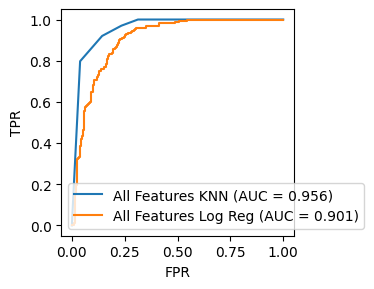

In [ ]:
fpr, tpr, thresh = roc_curve(y_test, y_prob[:,1])
fpr2, tpr2, thresh = roc_curve(y_test, y_prob2)
auc_score = auc(fpr, tpr)
auc_score2 = auc(fpr2, tpr2)
print(auc_score)
print(auc_score2)

plt.figure(figsize=(3,3),dpi=100)
plt.plot(fpr, tpr, label = 'All Features KNN (AUC = %0.3f)' %auc_score)

plt.plot(fpr2, tpr2, label = 'All Features Log Reg (AUC = %0.3f)' %auc_score2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

### Classification using KNN with Individual Risk Factors only

In [ ]:
# Arrays
accuracies = []
roc_auc_scores = []

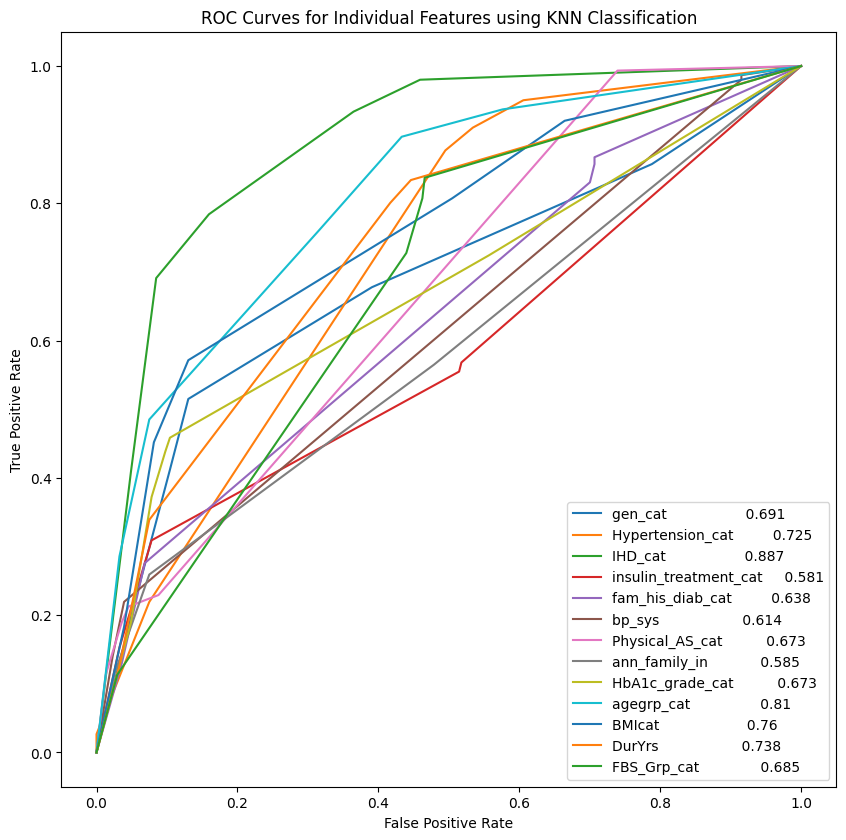

In [ ]:
feat = 0
plt.figure(figsize=(10,10),dpi=100)

for i in range(X_train.shape[1]):
  classifier = knn(n_neighbors = 5, metric = 'minkowski', p=2)
  classifier.fit(X_train[:, [feat]], y_train)

  y_p = classifier.predict(X_test[:, [feat]])
  y_prob = classifier.predict_proba(X_test[:, [feat]])

  acc = accuracy_score(y_test, y_p)
  accuracies.append(acc)

  aucc = roc_auc_score(y_test, y_prob[:, 1])
  roc_auc_scores.append(aucc)

    
  fpr, tpr, thresh = roc_curve(y_test, y_prob[:,1])
  auc_score = auc(fpr, tpr)

  string = f"{column_names[feat] :<20}{round(auc_score, 3) :>10}"
  plt.plot(fpr, tpr, label = string )

  feat = feat+1

# accuracies = []
# roc_auc_scores = [] # So we don't have to rerun the whole thing to see graph

plt.title('ROC Curves for Individual Features using KNN Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
for i in range(X_train.shape[1]):
  print("Feature: ", column_names[i], "          [AUC= %0.3f," %roc_auc_scores[i],"Accuracy= %0.3f]" %accuracies[i]) 

Feature:  gen_cat           [AUC= 0.691, Accuracy= 0.694]
Feature:  Hypertension_cat           [AUC= 0.725, Accuracy= 0.689]
Feature:  IHD_cat           [AUC= 0.887, Accuracy= 0.812]
Feature:  insulin_treatment_cat           [AUC= 0.581, Accuracy= 0.520]
Feature:  fam_his_diab_cat           [AUC= 0.638, Accuracy= 0.562]
Feature:  bp_sys           [AUC= 0.614, Accuracy= 0.528]
Feature:  Physical_AS_cat           [AUC= 0.673, Accuracy= 0.587]
Feature:  ann_family_in           [AUC= 0.585, Accuracy= 0.543]
Feature:  HbA1c_grade_cat           [AUC= 0.673, Accuracy= 0.673]
Feature:  agegrp_cat           [AUC= 0.810, Accuracy= 0.722]
Feature:  BMIcat           [AUC= 0.760, Accuracy= 0.722]
Feature:  DurYrs           [AUC= 0.738, Accuracy= 0.691]
Feature:  FBS_Grp_cat           [AUC= 0.685, Accuracy= 0.671]


In [ ]:
np.set_printoptions(3)
print(np.array(accuracies))

[0.694 0.689 0.812 0.52  0.562 0.528 0.587 0.543 0.673 0.722 0.722 0.691
 0.671]


In [ ]:
print(roc_auc_scores)

[0.690721482138799, 0.7254591102405661, 0.8868862748493079, 0.5813412403822221, 0.6376519094873765, 0.6140822664949626, 0.6734608849978898, 0.5848420574198925, 0.6733689006244115, 0.8098304241020703, 0.7602346142608244, 0.7384884262014783, 0.6850400943651456]


In [ ]:
column_names = np.array(column_names)
names = column_names[:-1]
roc_auc_scores = np.array(roc_auc_scores)
comb = np.concatenate((names.reshape(len(names),1), roc_auc_scores.reshape(len(roc_auc_scores),1)),1)

In [ ]:
sorted = comb[comb[:,1].argsort()]
#print(sorted)
#print()

median = math.floor(sorted.shape[0]/2) # Index of median element
threshold = sorted[median][1]
print("Threshold is ", threshold)
print()


def assign_class_labels(comb):
  labeled = comb
  i = 0
  print("Predicted Risk Factor Labels:")
  for pair in comb:
    if pair[1] <= threshold:
      labeled[i][1] = 2
      print("Secondary: ",pair[0])
    else:      
      labeled[i][1] = 1
      print("Primary: ", pair[0])

    i = i+1

  print()
  return labeled


lab = assign_class_labels(comb)
print(lab)

Threshold is  0.6850400943651456

Predicted Risk Factor Labels:
Primary:  gen_cat
Primary:  Hypertension_cat
Primary:  IHD_cat
Secondary:  insulin_treatment_cat
Secondary:  fam_his_diab_cat
Secondary:  bp_sys
Secondary:  Physical_AS_cat
Secondary:  ann_family_in
Secondary:  HbA1c_grade_cat
Primary:  agegrp_cat
Primary:  BMIcat
Primary:  DurYrs
Secondary:  FBS_Grp_cat

[['gen_cat' '1']
 ['Hypertension_cat' '1']
 ['IHD_cat' '1']
 ['insulin_treatment_cat' '2']
 ['fam_his_diab_cat' '2']
 ['bp_sys' '2']
 ['Physical_AS_cat' '2']
 ['ann_family_in' '2']
 ['HbA1c_grade_cat' '2']
 ['agegrp_cat' '1']
 ['BMIcat' '1']
 ['DurYrs' '1']
 ['FBS_Grp_cat' '2']]


## Evaluate Risk Factor Clustering

In [ ]:
from prettytable import PrettyTable

In [ ]:
gold_truth = [['gen_cat', 2],
 ['Hypertension_cat', 1],
 ['IHD_cat', 2],
 ['insulin_treatment_cat', 1],
 ['fam_his_diab_cat', 2],
 ['bp_sys', 1],
 ['Physical_AS_cat', 2],
 ['ann_family_in', 2],
 ['HbA1c_grade_cat', 1],
 ['agegrp_cat', 2],
 ['BMIcat', 2],
 ['DurYrs', 1],
 ['FBS_Grp_cat', 1]]


In [ ]:
def confusion(labeled, gold_truth):
  i = 0
  tp = 0
  tn = 0
  fp = 0
  fn = 0
  wrong_features = []

  for pairs in  gold_truth:
    a = labeled[i][1].astype(int) # Predicted
    b = np.int64(pairs[1]) # Actual
    
    if (a == 1 and b==1):
      tp = tp+1
    elif(a==2 and b==2):
      tn = tn+1
    elif(a==1 and b==2):
      fp = fp+1
      wrong_features.append([pairs[0], i])
    elif (a==2 and b==1):
      fn = fn + 1
      wrong_features.append([pairs[0], i])
    
    i = i+1

  table = PrettyTable(['', 'Actual Primary', 'Actual Secondary'])
  table.add_row(['Predicted Primary', tp, fp])
  table.add_row(['Predicted Secondary', fn, tn])
  return table, tp, tn, fp, fn, wrong_features




In [ ]:
def comparison_table(lab, gold_truth):
  table = PrettyTable(['Risk Factor', 'Actual', 'Predicted', 'Correctness'])
  i = 0
  for pairs in  gold_truth:
    a = lab[i][1].astype(int)
    b = np.int64(pairs[1])
    correct = "Correct" if a==b else "Wrong"
    table.add_row([pairs[0], a, b, correct])
    i = i+1

  confusion_mat, tp, tn, fp, fn, wrongs = confusion(lab, gold_truth)
  print("Comparison Table:")
  print(table)

  print("Wrongly Classified Features:")
  # print(wrongs)
  [print('  ',thing) for thing, i in wrongs]
  print()
  print("Confusion Matrix:")
  print(confusion_mat)
  return tp, tn, fp, fn

  

In [ ]:
tp, tn, fp, fn = comparison_table(lab, gold_truth)
print("Features in Correct clusters = ", tp+tn)
print("Features in Wrong clusters = ", fp+fn)

Comparison Table:
+-----------------------+--------+-----------+-------------+
|      Risk Factor      | Actual | Predicted | Correctness |
+-----------------------+--------+-----------+-------------+
|        gen_cat        |   1    |     2     |    Wrong    |
|    Hypertension_cat   |   1    |     1     |   Correct   |
|        IHD_cat        |   1    |     2     |    Wrong    |
| insulin_treatment_cat |   2    |     1     |    Wrong    |
|    fam_his_diab_cat   |   2    |     2     |   Correct   |
|         bp_sys        |   2    |     1     |    Wrong    |
|    Physical_AS_cat    |   2    |     2     |   Correct   |
|     ann_family_in     |   2    |     2     |   Correct   |
|    HbA1c_grade_cat    |   2    |     1     |    Wrong    |
|       agegrp_cat      |   1    |     2     |    Wrong    |
|         BMIcat        |   1    |     2     |    Wrong    |
|         DurYrs        |   1    |     1     |   Correct   |
|      FBS_Grp_cat      |   2    |     1     |    Wrong    |
+-----